In [1]:
%matplotlib inline

The FEniCS project is a collection of software designed for the automated solution of partial differential equations using the finite element method. It handles a lot of the busywork involved for you, and more or less automates everything except deriving the weak formulation. Both Python and C++ interfaces exist. It can be obtained at https://fenicsproject.org/download/. Once properly installed, you can start using it in a Python program by the following:

In [2]:
# This is kind of bad practice, but for small scripts it is very convenient
# DOLFIN is the computational backend of the FEniCS project
from dolfin import * 

## The stationary cable equation
In this notebook, we will solve the cable equation in FEniCS. Let $\Omega = [0, 1]$ be an electrical cable transmitting signals between 0 and 1 by conducting a current. The cable is also leaky, meaning that some current going into it doesn't reach the other end, instead escaping along the way. The cable equation then says that the electric potential $U(x)$ at a point on the cable satisfies the equation $$\lambda^2 \frac {\partial^2 U} {\partial^2 x} = \tau \frac {\partial U} {\partial t} + U$$ 

Here $\lambda, \tau$ are length and time constants. We consider what happens if we fix the potential to $2$ at the left end of the cable and to $1$ at the right and of the cable and just leave it be until it settles in a steady state. In the steady state we will have $\frac {\partial U} {\partial t} = 0$, so we can find the steady state by solving the equation $$\lambda^2 \frac {\partial^2 U} {\partial^2 x} - U = 0$$

with the boundary conditions $U(0) = 2, \: U(1) = 1$ For brevity, we write $\frac {\partial U} {\partial x} = U_x$ and $\frac {\partial^2 U} {\partial^2 x} = U_{xx}$.

## Putting the cable equation in weak form
As before, we start out by deriving the weak form of our problem. We do this by multiplying by a test function $V$, integrating over our whole domain, and manipulating the integral using integration by parts until no second derivatives occur. 

$$ \int \limits_0^1 \lambda^2 U_{xx} V - UV \: \text{dx} \: = \: \Big\rvert \lambda^2 U_xV \Big\rvert_0^1 - \int \limits_0^1 UV  + \lambda^2U_xV_x \: \text{dx} \: = \:-U_x(0)V(0) + \lambda^2 U_x(1)V(0) - \int \limits_0^1 UV + \lambda^2U_xV_x \: \text{dx}$$

As this has no second derivatives, this is the weak form of our equation.

## Discretizing the domain and space of functions
We can now use FEniCS to solve our problem. First, we discretize our domain by creating a mesh of $\Omega$. 

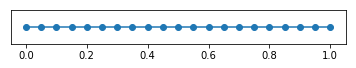

In [3]:
mesh = UnitIntervalMesh(20) # 20 is number of intervals Omega is divided intoc
plot(mesh);


Next, choose a space of functions to use for approximating $U$. We use the space of continuous piecewise linear functions on our mesh. Denote this space by $W$.

In [4]:
elt = FiniteElement("CG", interval, 1) # here interval is a FEniCS builtin representing a single interval
W = FunctionSpace(mesh, elt)

Think of `elt` as a function space of linear functions living on a single subinterval of our mesh. The call to `FunctionSpace` then takes this small 'model' function space living in a single subinterval of the mesh and builds a 'global' function space $W$ by effectively gluing together copies of `elt`. This is not 100% accurate, but a good mental picture.


## Specifying the weak formulation
Next, all we need to do is tell FEniCS the weak formulation of our problem.

In [5]:
lbd = Constant(1)

V = TestFunction(W)
U = TrialFunction(W) # the TrialFunction is basically a symbol representing the unknown

a = - (U * V + lbd**2 * U.dx(0) * V.dx(0)) * dx # .dx(0) means first derivative
L = Constant(0) * V * dx

Above `a` is the left hand side and `L` the right hand side of our equation $$- \int \limits_0^1 UV + U_xV_x \: \text{dx} = 0$$


## Specifying boundary conditions
Note that we are ignoring the boundary terms $-U_x(0)V(0) + U_x(1)V(0)$. Simply put, this is due to the way FEniCS handles boundary conditions. You can ignore it if you want, but if you are interested, there is a brief explanation at the end of this notebook. Generally speaking, you can ignore the boundary terms where there are Dirichlet boundary conditions so as long as you remember to tell FEniCS about the boundary conditions. So let's do that!

In [6]:
bc_l = DirichletBC(W, 1, "on_boundary && near(x[0], 0)")
bc_r = DirichletBC(W, 2, "on_boundary && near(x[0], 1)")

The second argument is the value our boundary condition says the function should have, and the last argument is where the boundary condition should apply.

Now we have done basically all we need to do to solve our equation:

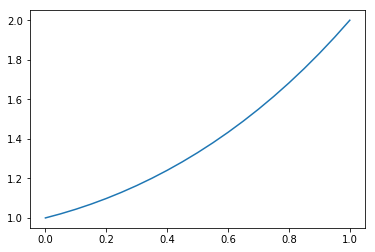

In [7]:
U_sol = Function(W)      # place to store the solution
bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem

solve(a == L, U_sol, bcs)
plot(U_sol)

And that's it! We have solved a PDE in 12 lines of code. That's pretty good value for money. The same procedure can be carried through for more complicated equations as well. Though a bit more code may be required to specify the domains, boundaries and weak forms, the overall structure is still the same:

1. Define the domain
2. Define the `FunctionSpace` you want to use for approximating your solution
3. Specify the weak form so FEniCS understands it
4. Specify the boundary conditions

## Where did the boundary terms go, and when can I ignore them? (can be skipped)
To make it clear what is happening with the boundary terms we ignored, what FEniCS does behind the scenes is the following:

In [8]:
A = assemble(a)
b = assemble(L)

print("\nBefore BCs are applied without bdy term: \n")
print(A.array())
print(b.array())


bc_l.apply(A)
bc_r.apply(A)
bc_l.apply(b)
bc_r.apply(b)

print("\nAfter BCs are applied without bdy term: \n")
print(A.array())
print(b.array())


Before BCs are applied without bdy term: 
[[-20.01666667  19.99166667   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 19.99166667 -40.03333333  19.99166667   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.          19.99166667 -40.03333333  19.99166667   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.          19.99166667 -40.03333333  19.99166667
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.          

/home/karlerik/software/anaconda2/envs/vasculatureenv/lib/python2.7/site-packages/dolfin/cpp/la.py:1123: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/home/karlerik/software/anaconda2/envs/vasculatureenv/lib/python2.7/site-packages/dolfin/cpp/la.py:1123: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


This tells you how `DirichletBC`s are applied in FEniCS, and why adding the boundary terms wouldn't matter. When you give FEniCS a boundary condition, it replaces the equation it got from putting $V=\phi_i$ for the right $i$ by one reading $u_i = $ the value $U$ is supposed to have there, meaning a row of $A$ is replaced by one with a single 1 and the rest 0, and the correponding part of $b$ set to the right value.

Note that you are only allowed to ignore the boundary terms when you have a boundary condition of the form $U = $ constant at every part of the boundary. Such boundary conditions are called *Dirichlet* boundary conditions. Sometimes you might have conditions involving the derivative of $U$ instead. Those are called *Neumann* or *Robin* boundary conditions, and generally mean you have to add a term to `L`. 

If you had wanted to add boundary terms, this could be done as follows:

In [9]:
a = - (U * V + U.dx(0) * V.dx(0)) * dx + U.dx(0) * V * ds  # ds means integrate over boundary
A = assemble(a)
b = assemble(L)

print("\nBefore BCs are applied with bdy term: \n",)
print(A.array())
print(b.array())

bc_l.apply(A)
bc_r.apply(A)
bc_l.apply(b)
bc_r.apply(b)

print("\nAfter BCs are applied with bdy term: \n")
print(A.array())
print(b.array())


Before BCs are applied with bdy term: 
[[-1.66666667e-02 -8.33333333e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.99916667e+01 -4.00333333e+01  1.99916667e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.99916667e+01 -4.00333333e+01  1.99916667e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+0

/home/karlerik/software/anaconda2/envs/vasculatureenv/lib/python2.7/site-packages/dolfin/cpp/la.py:1123: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/home/karlerik/software/anaconda2/envs/vasculatureenv/lib/python2.7/site-packages/dolfin/cpp/la.py:1123: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


Notice that although the matrix `A` becomes different when you add the boundary term, the only difference is in the first and last row, which corresponds to nodes where we have boundary conditions. This is why you can ignore the boundary term where you have a Dirichlet boundary condition.

## Exercises




### Exercise 1
Solve the equation $u_{x} = 2u $ in FEniCS on the interval $[0, 1]$ with the condition $u(0) = 1$. In this case, the solution should be $u(x) = e^{2x}$, so $u(1)$ should be $e^2$. How close is your computed solution? How fast does the error decrease if you double the number of points in your mesh? 


### Exercise 2
What happens if you also apply the condition $u(1) = 2$ in the problem from the previous exercise? Why do you think that 
is? 

# Slides

In [10]:
%matplotlib inline

# This is kind of bad practice, but for small scripts it is very convenient
# DOLFIN is the computational backend of the FEniCS project
from dolfin import * 

## The cable equation
Let $\Omega = [0, 1]$ be a leaky electrical cable transmitting signals from 0 to 1, and $U(x)$ the voltage at $x$. 

Cable equation: $$\lambda^2 \frac {\partial^2 U} {\partial^2 x} = \tau \frac {\partial U} {\partial t} + U$$ 

At steady state, $\frac {\partial U} {\partial t} = 0$, so: $$\lambda^2 \frac {\partial^2 U} {\partial^2 x} - U = 0$$

Boundary conditions: $U(0) = 2, \: U(1) = 1$ 

For simplicity, we take $\lambda = 1$.

##  Weak form of cable equation
Multiply by a test function $V$, integrating over $\Omega$, and integrate by parts until no second derivatives occur: 

$$ \int \limits_0^1 U_{xx} V - UV \: \text{dx} \: = \: \Big\rvert U_xV \Big\rvert_0^1 - \int \limits_0^1 UV  + U_xV_x \: \text{dx} \: = \:-U_x(0)V(0) + U_x(1)V(0) - \int \limits_0^1 UV + U_xV_x \: \text{dx}$$


## Implementation in FEniCS: discretizing $\Omega$

`elt` is a function space of linear functions living on a single subinterval of our mesh.

`FunctionSpace` takes this 'local' function space and builds a 'global' function space $W$ by gluing together copies of `elt`. 

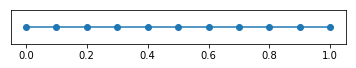

In [11]:
mesh = UnitIntervalMesh(10) # 10 is number of intervals Omega is divided into
plot(mesh);

elt = FiniteElement("CG", interval, 1) # interval is a FEniCS builtin representing a single subinterval
W = FunctionSpace(mesh, elt)

## Specifying the weak form

In [12]:
V = TestFunction(W)
U = TrialFunction(W) # symbol representing the unknown

a = - (U * V + U.dx(0) * V.dx(0)) * dx # .dx(0) means first derivative
L = Constant(0) * V * dx

`a` is the left hand side and `L` the right hand side of our equation $$- \int \limits_0^1 UV + U_xV_x \: \text{dx} = 0$$
The boundary term $-U_x(0)V(0) + U_x(1)V(0)$ could be added to the form as follows, but we ignore it for now.

In [13]:
# a = - (U * V + U.dx(0) * V.dx(0)) * dx + U.dx(0) * V * ds # ds means integrate over boundary

## Specifying boundary conditions and calling 'solve'

Calling FFC just-in-time (JIT) compiler, this may take some time.


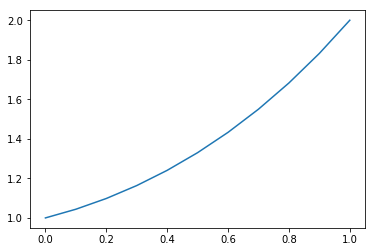

In [14]:
bc_l = DirichletBC(W, 1, "on_boundary && near(x[0], 0)")
bc_r = DirichletBC(W, 2, "on_boundary && near(x[0], 1)")

U_sol = Function(W)      # place to store the solution
bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem

solve(a == L, U_sol, bcs)
plot(U_sol)

We have solved a PDE in 12 lines of code! Quick summary:

1. Define the domain
2. Define the `FunctionSpace` you want to use for approximating your solution
3. Specify the weak form so FEniCS understands it
4. Specify the boundary conditions

## Where did the boundary terms go? (can be skipped)
Let's take a look at the matrices FEniCS builds:

In [15]:
a =  - (U * V + U.dx(0) * V.dx(0)) * dx

A = assemble(a)
b = assemble(L)

print "\nBefore BCs are applied without bdy term: \n",
print A.array()
print b.array()


bc_l.apply(A)
bc_r.apply(A)
bc_l.apply(b)
bc_r.apply(b)

print "\nAfter BCs are applied without bdy term: \n"
print A.array()
print b.array()


Before BCs are applied without bdy term: 
[[-10.03333333   9.98333333   0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  9.98333333 -20.06666667   9.98333333   0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           9.98333333 -20.06666667   9.98333333   0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           9.98333333 -20.06666667   9.98333333
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           9.98333333 -20.06666667
    9.98333333   0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           9.98333333
  -20.06666667   9.98333333   0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    9.98333333 -20.06666667   9.98333333   0.           0.
    0.     

/home/karlerik/software/anaconda2/envs/vasculatureenv/lib/python2.7/site-packages/dolfin/cpp/la.py:1123: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/home/karlerik/software/anaconda2/envs/vasculatureenv/lib/python2.7/site-packages/dolfin/cpp/la.py:1123: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


In [16]:
a = - (U * V + U.dx(0) * V.dx(0)) * dx + U.dx(0) * V * ds  # ds means integrate over boundary
A = assemble(a)
b = assemble(L)

print "\nBefore BCs are applied with bdy term: \n",
print A.array()
print b.array()

bc_l.apply(A)
bc_r.apply(A)
bc_l.apply(b)
bc_r.apply(b)

print "\nAfter BCs are applied with bdy term: \n"
print A.array()
print b.array()


Before BCs are applied with bdy term: 
[[-3.33333333e-02 -1.66666667e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.98333333e+00 -2.00666667e+01  9.98333333e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.98333333e+00 -2.00666667e+01  9.98333333e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.98333333e+00 -2.00666667e+01
   9.98333333e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.98333333e+00
  -2.00666667e+01  9.98333333e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000

/home/karlerik/software/anaconda2/envs/vasculatureenv/lib/python2.7/site-packages/dolfin/cpp/la.py:1123: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/home/karlerik/software/anaconda2/envs/vasculatureenv/lib/python2.7/site-packages/dolfin/cpp/la.py:1123: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


Notice that although the boundary term matters, it only matters at the nodes where we have Dirichlet BCs. As a guideline, you can assume that the test function $v$ will be 0 where you have Dirichlet BCs.